#Descrizione

In questo notebook viene implementata una rete neurale CONVLSTM2D.

Sono implementati 3 modelli ed ogni modello utilizza immagini la cui reshape è 128x64 (cropped).

Dopodichè le immagini sono ridimensionate in 3 versioni:

*    (16, 8, 8, 8)
*    (32, 16, 16, 1)
*    (8, 32, 32, 1)

Quest'ultimo reshape è necessario per poter trasformare un'unica immagine passata alla neural network come multiple sotto-immagini, su cui sviluppare la rete neurale ricorrente: ogni sotto-immagine sarà un time-step.

Sono presenti grafici circa la validation accuracy, validation loss, confusion matrix e grafici che analizzano gli errori di classificazione: per lista offuscamento applicata, per lista offuscamento ignorando l'ordine degli offuscamenti, per classe e per offuscamento applicato in percentuale al numero di offuscamenti effettuati.

In fondo al notebook vi è un grafo che mostra la validation accuracy dei tre modelli a confronto.

Parametri:

database_scelto = '9k', croppato.

batch_size = 64

num_units1 = 141

channels = 1 o 8

n_epochs = 100

patience = 10

Il formato (A, M, N, C):
* A indica il numero di sotto-immagini che compongono l'immagine, le cui dimensioni sono MxNxC.
* M righe
* N colonne
* C channels

I time-steps saranno quindi pari ad A e il numero di features è indicato dalla grandezza delle sotto-immagini.

##(16, 8, 8, 8)
(16, 8, 8, 8): Accuratezza 92,75%, 20 epochs, 2035s.
* ('Flatten-RandomFuns-Split', 22)
* ('EncodeArithmetic-Flatten-RandomFuns', 21)
* ('EncodeLiterals-InitOpaque-Split', 19)

##(32, 16, 16, 1)
(32, 16, 16, 1): Accuratezza 89,13%, 15 epochs, 8991s.
* ('EncodeArithmetic-Flatten-RandomFuns', 27)
* ('Flatten-RandomFuns-Split', 26)
* ('EncodeLiterals-RandomFuns-Split', 20)

##(8, 32, 32, 1)
(8, 32, 32, 1): Accuratezza 90,04%, 13 epochs, 8426s.
* ('Flatten-RandomFuns-Split', 26)
* ('EncodeArithmetic-RandomFuns-Split', 21)
* ('InitEntropy-InitOpaque-RandomFuns', 16)


In [22]:
%tensorflow_version 1.x

#Import

In [23]:
import tensorflow as tf
from tensorflow import keras as ks


import numpy as np
import pandas as pd

import time
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
'''
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers import Conv2D
'''
print(tf.__version__)

1.15.2


#Parametri modello 1

In [24]:
database_scelto = '9k' #or '18k' or '14k'

dim1 = 128
dim2 = 64
batch_size = 64

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 8

time_steps = 8
n_features = 8

n_epochs = 100
patience = 10

In [25]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [26]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

Cloning into 'NN_modules'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 163 (delta 4), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (163/163), 2.83 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [27]:
import Defining_Methods as my_lib

In [28]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

9400
START IMAGE INPUT
END IMAGE INPUT


In [29]:
temp_db = (train_images, test_images, validation_images)
train_images, test_images, validation_images, n_ts_blocks = my_lib.reshape_for_ConvLSTM2D(temp_db, time_steps, n_features, channels)

In [30]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 1

In [31]:
modelCONVLSTM2D, hist, time_callback = my_lib.modelConvLSTM2D(num_units1, time_steps, n_features, n_ts_blocks, batch_size, channels, n_classes, patience, sub_db, n_epochs)

##Risultati modello 1

In [32]:
number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)

test_accuracy = modelCONVLSTM2D.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

1504/1504 [==============================] - 3s 2ms/sample - loss: 0.6311 - acc: 0.8697
Total epochs 17
525.7240190505981 s


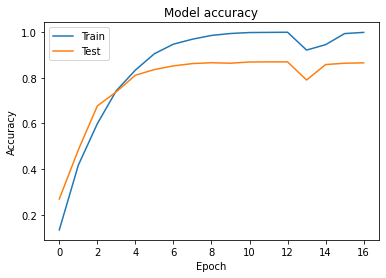

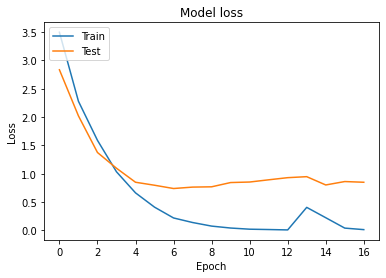

In [33]:
plt.show(my_lib.plot_model_acc(hist))
plt.show(my_lib.plot_model_loss(hist))

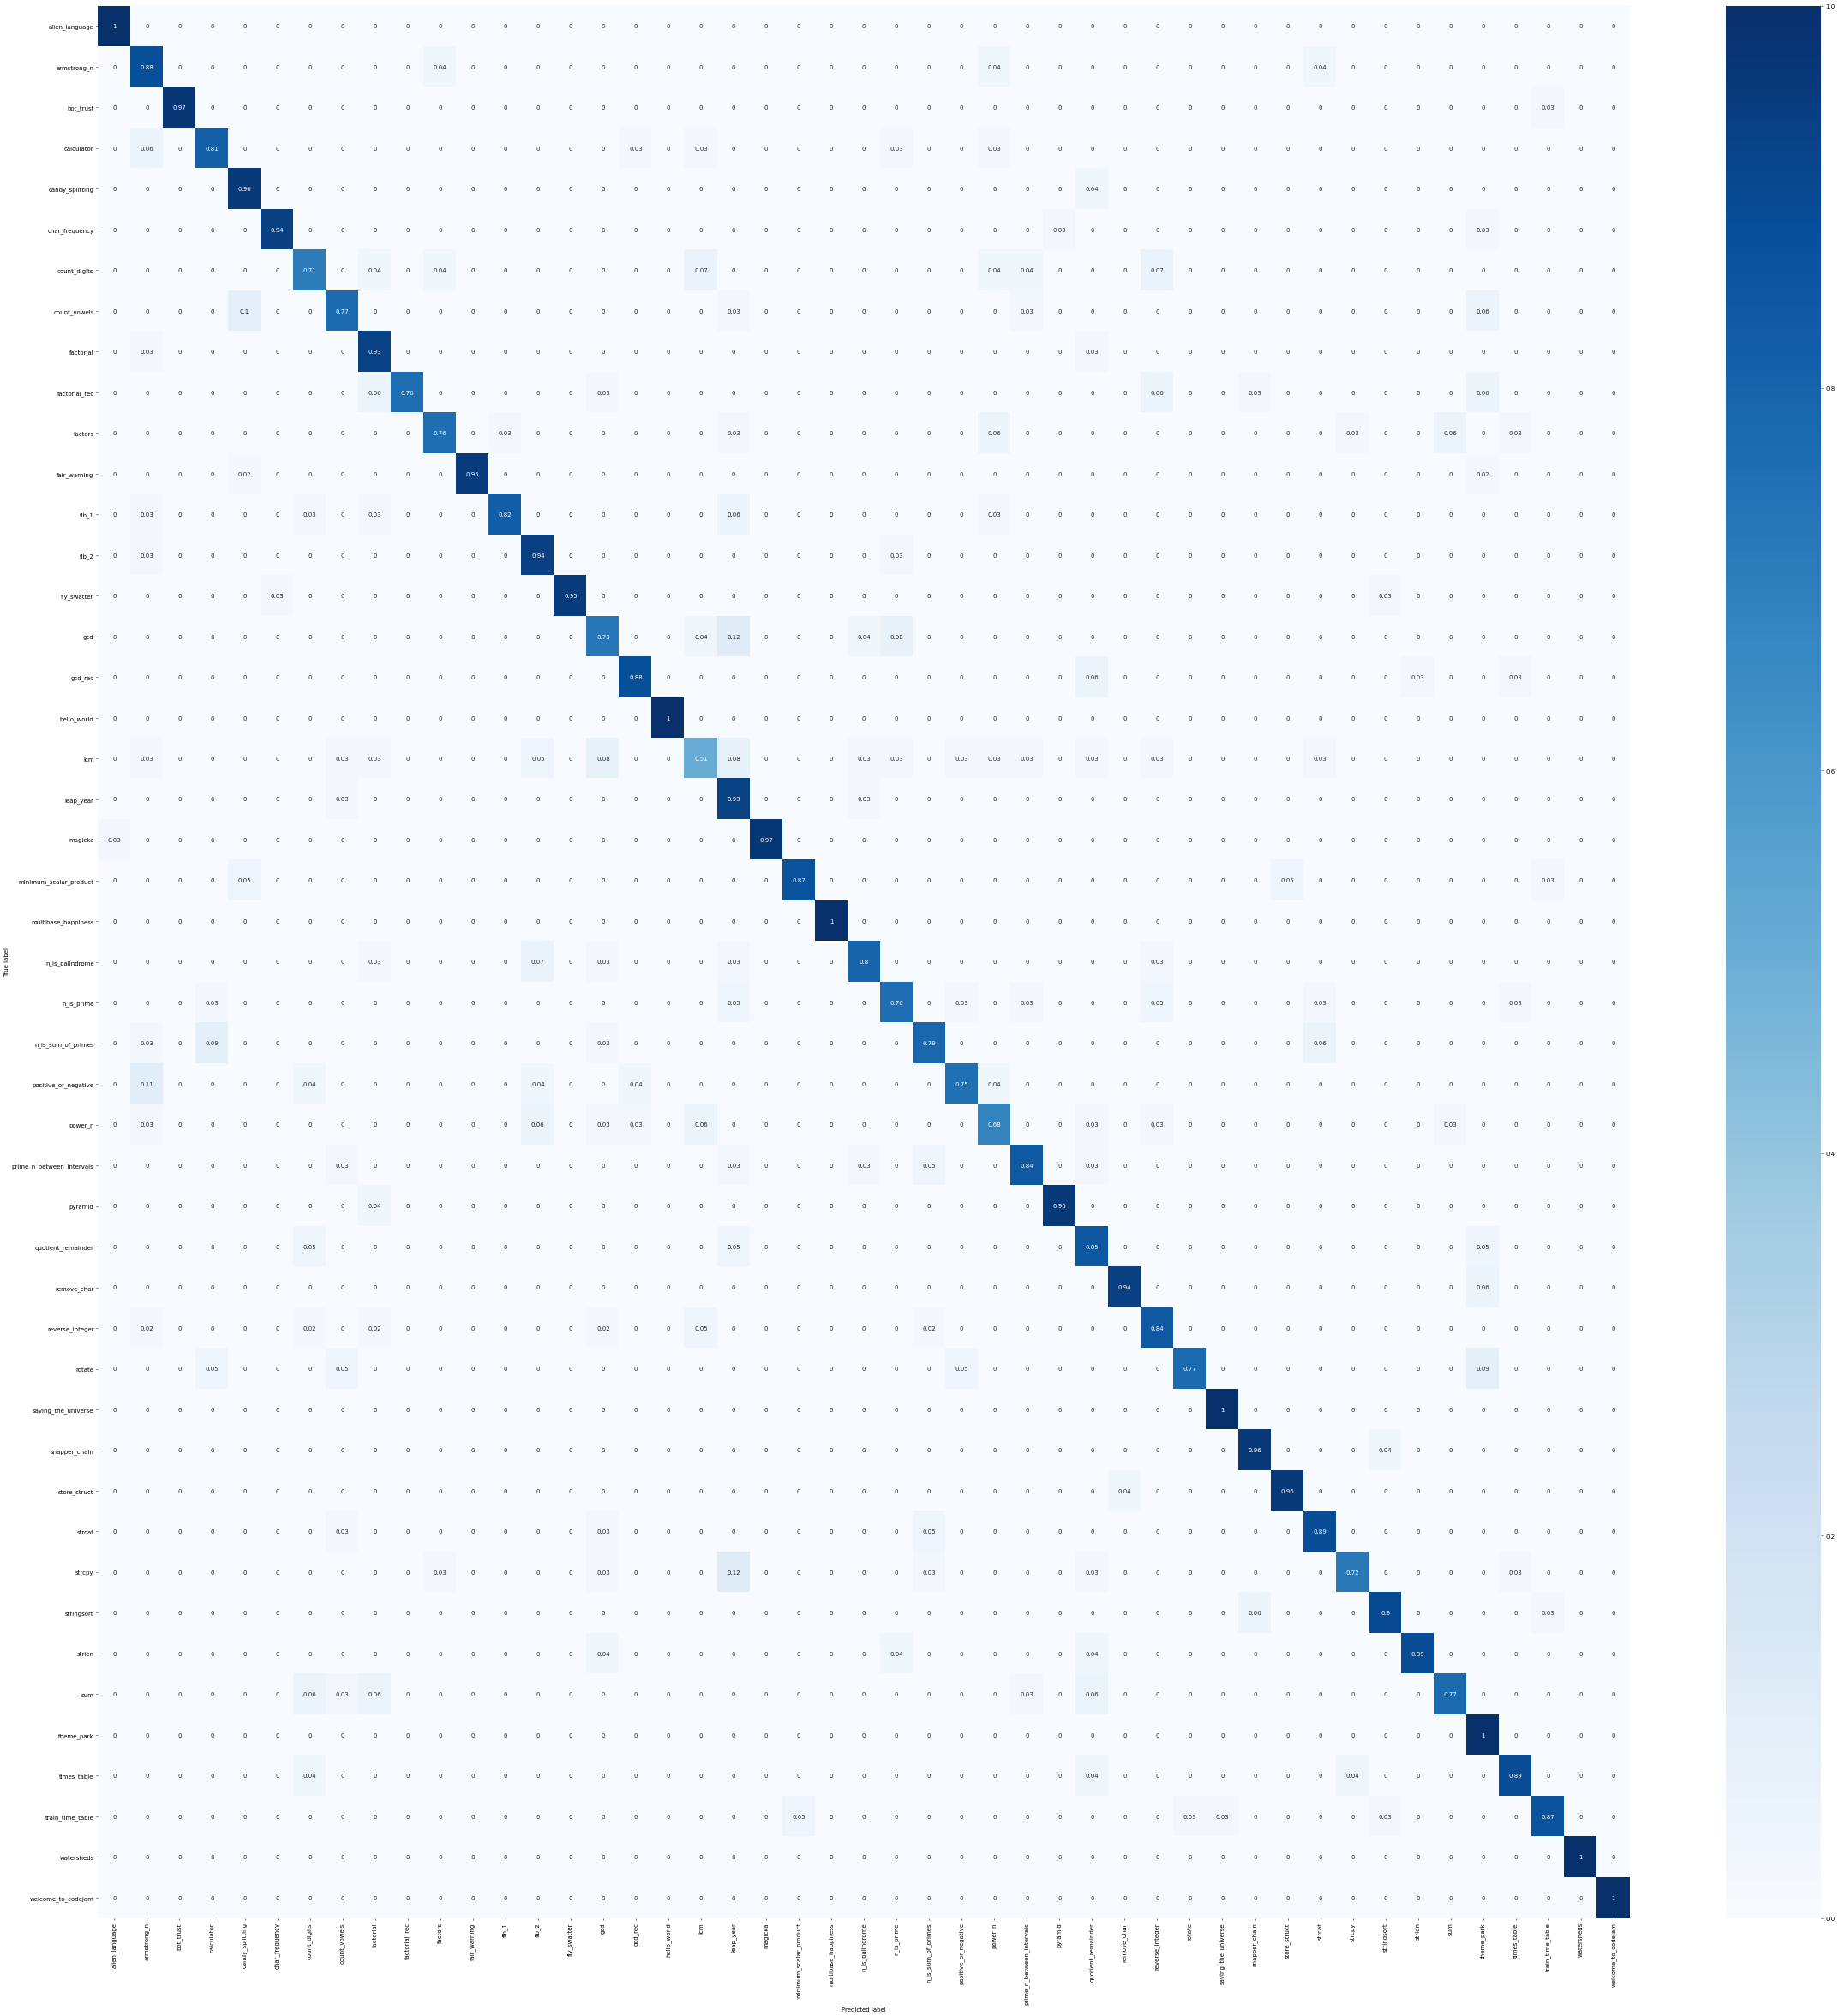

In [34]:
plt.show(my_lib.plot_conf_matrix(modelCONVLSTM2D, validation_images, validation_labels_encoded, label_encoder))

Grafo degli errori focalizzato sul singolo set di offuscamento


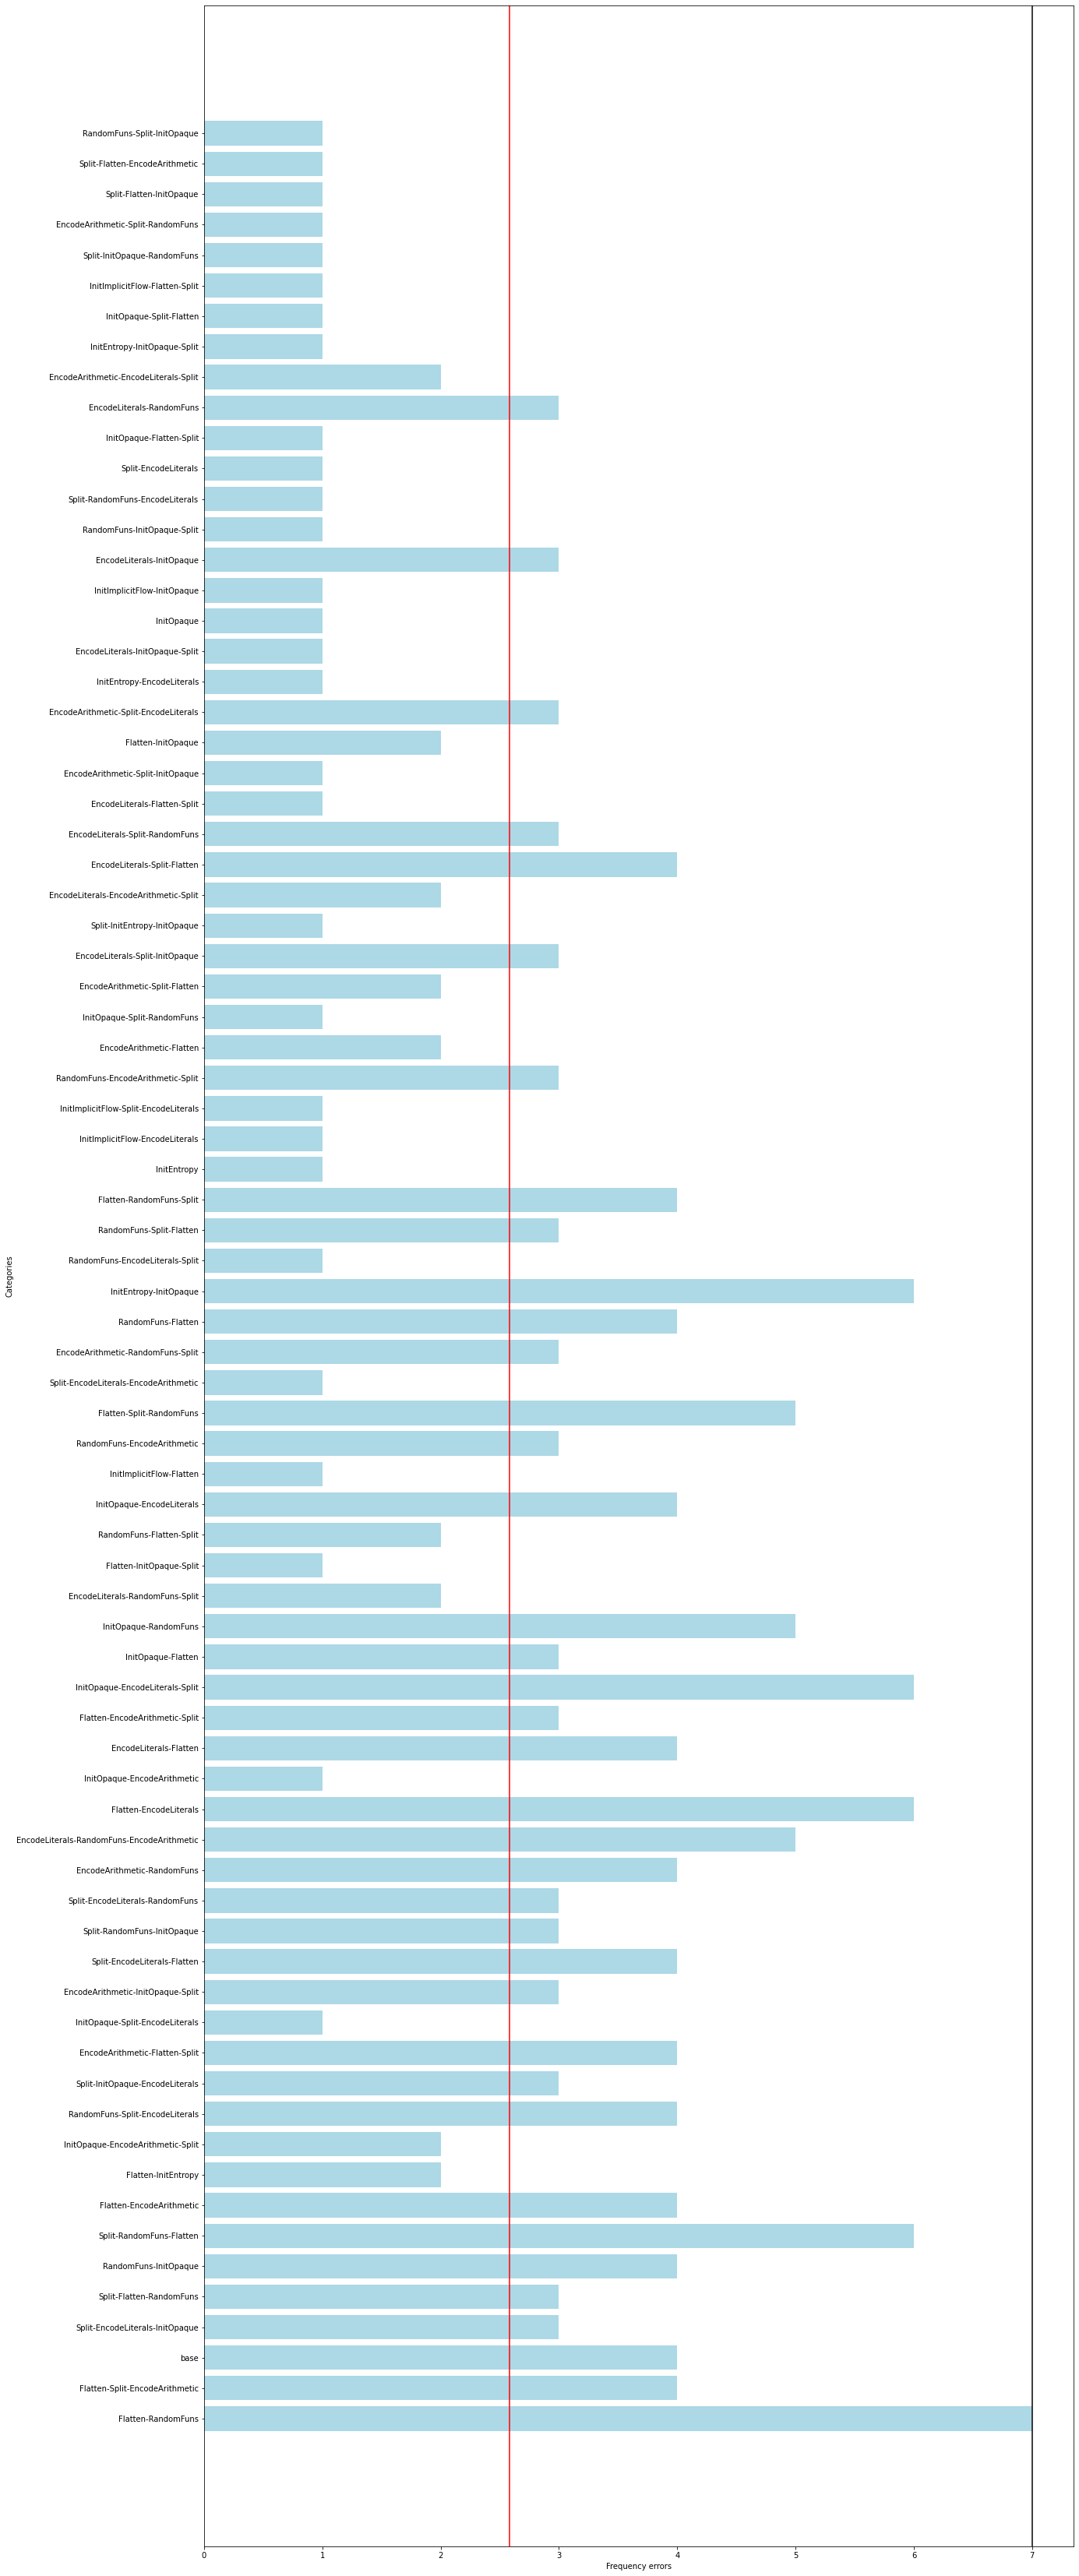


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


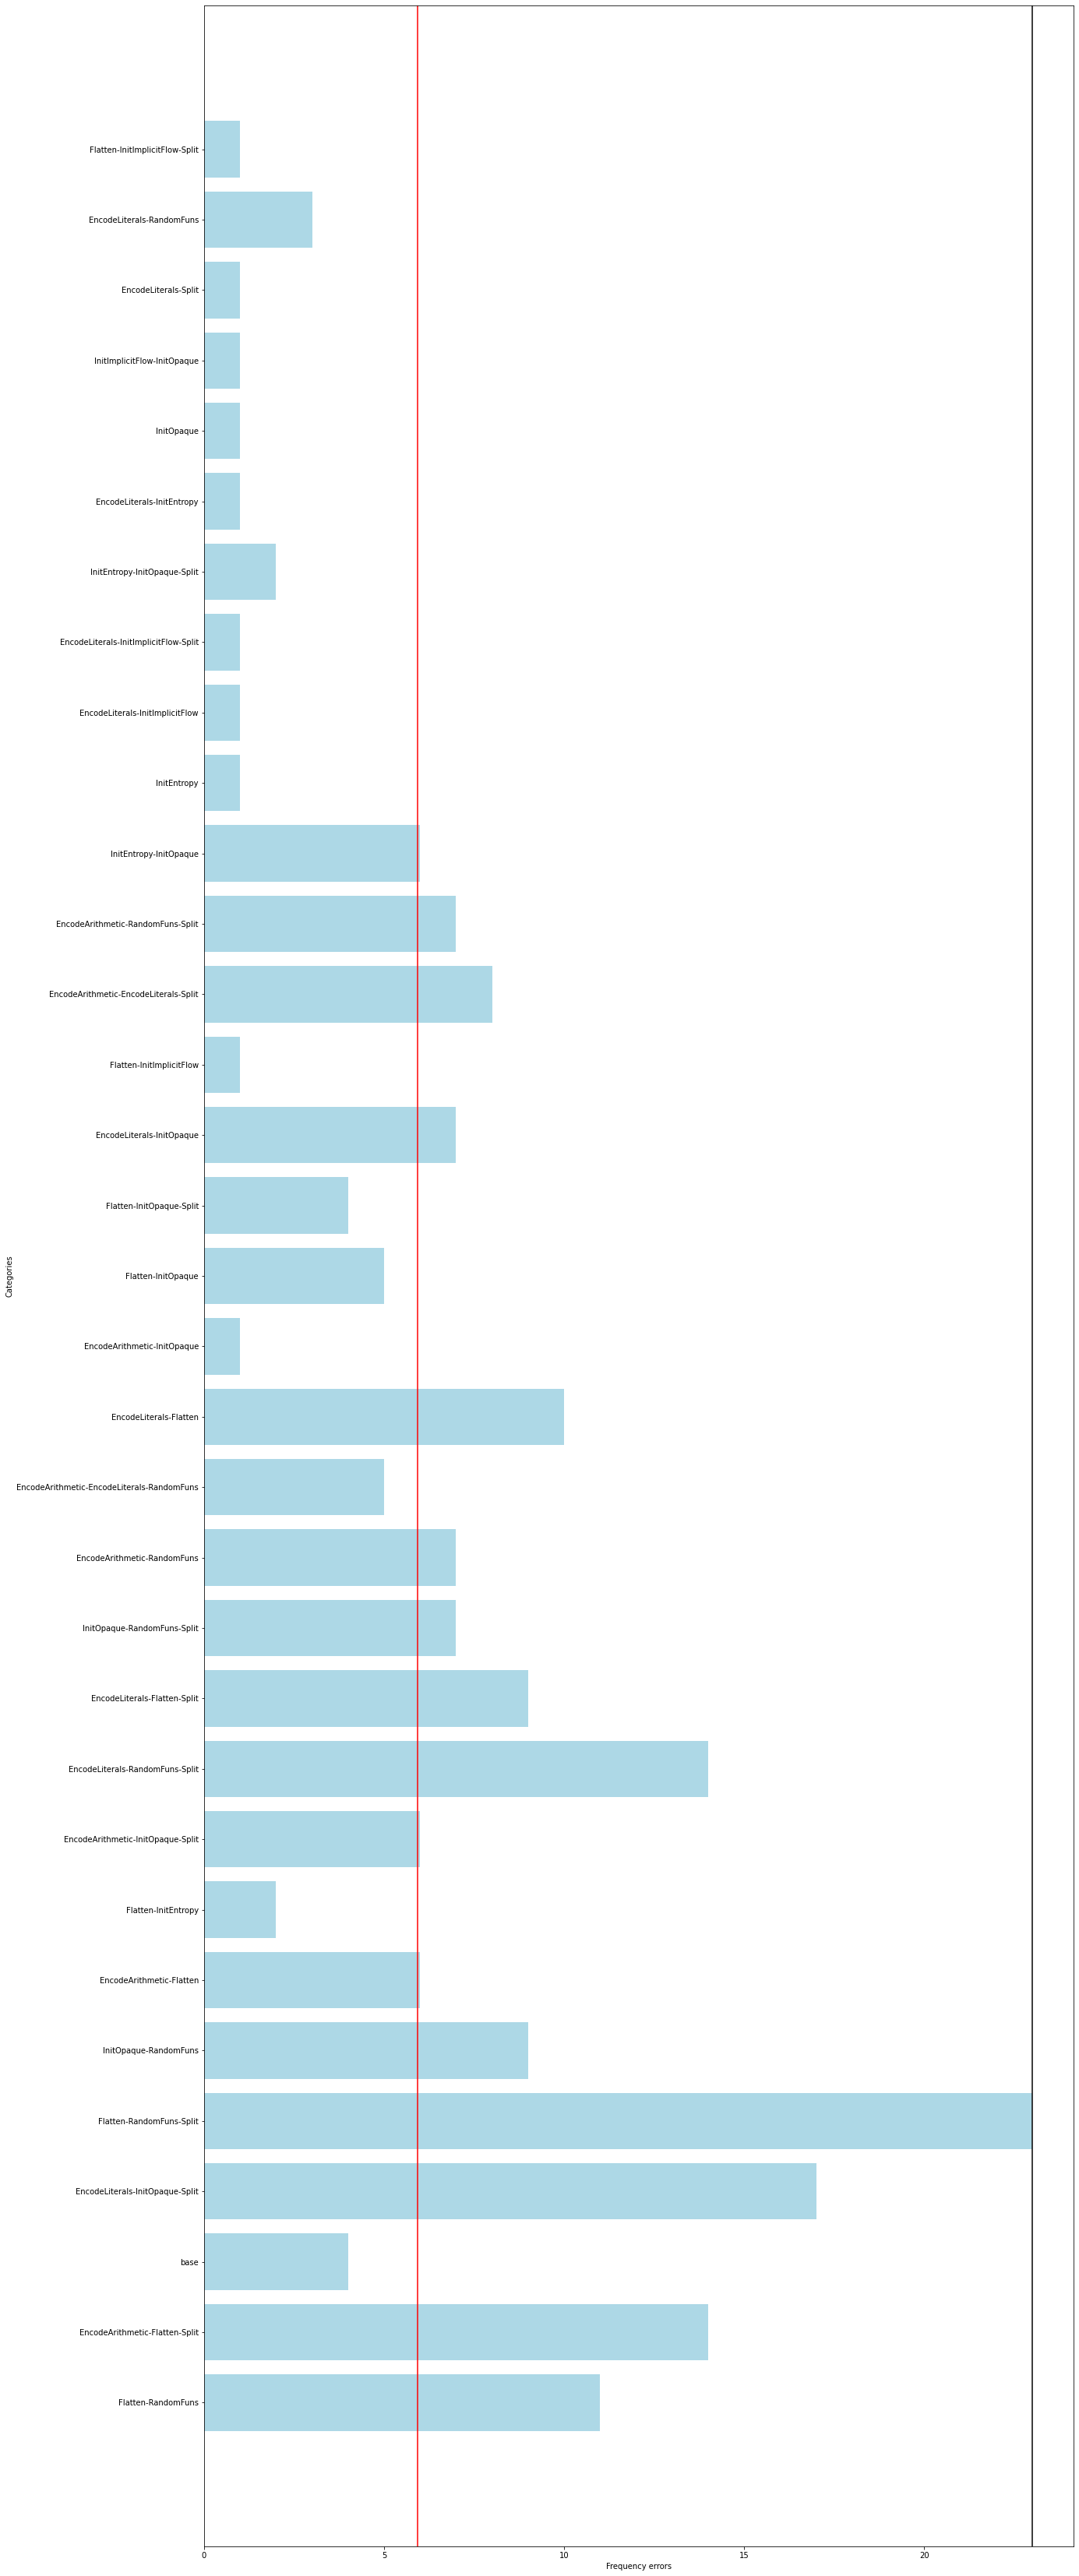


Grafo degli errori per classe


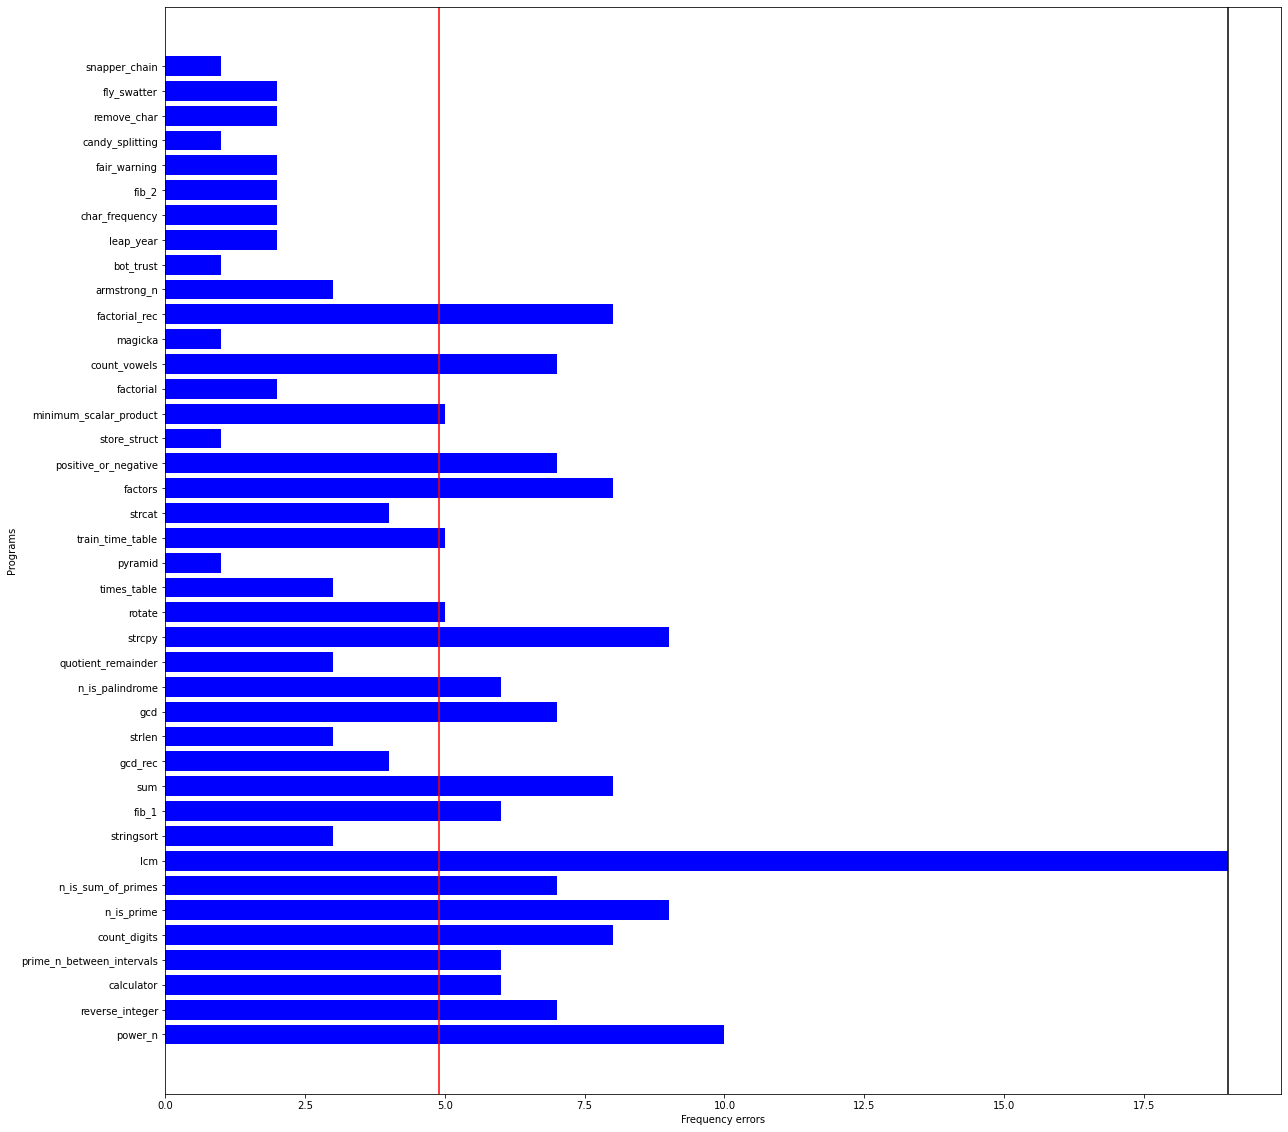


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


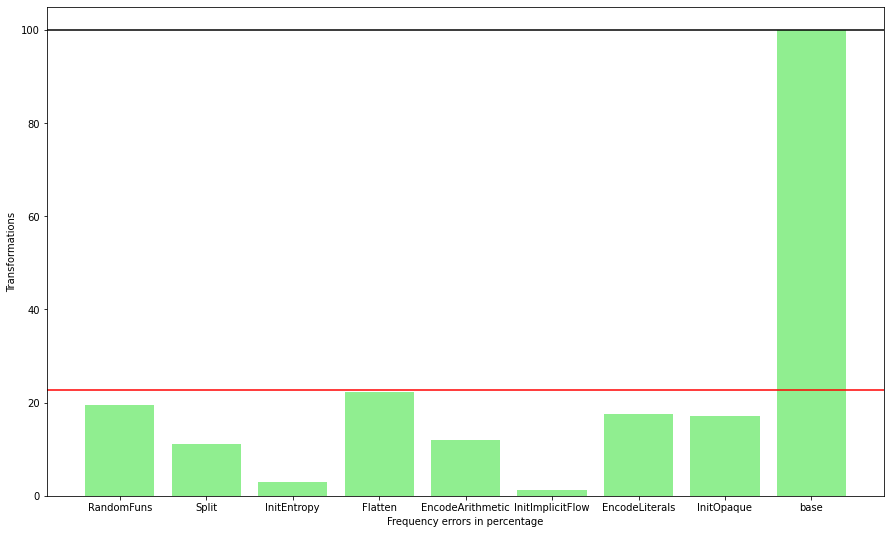

In [35]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelCONVLSTM2D, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))


In [36]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-RandomFuns-Split', 23)
('EncodeLiterals-InitOpaque-Split', 17)
('EncodeArithmetic-Flatten-Split', 14)
('EncodeLiterals-RandomFuns-Split', 14)
('Flatten-RandomFuns', 11)
('EncodeLiterals-Flatten', 10)
('InitOpaque-RandomFuns', 9)
('EncodeLiterals-Flatten-Split', 9)
('EncodeArithmetic-EncodeLiterals-Split', 8)
('InitOpaque-RandomFuns-Split', 7)
('EncodeArithmetic-RandomFuns', 7)
('EncodeLiterals-InitOpaque', 7)
('EncodeArithmetic-RandomFuns-Split', 7)
('EncodeArithmetic-Flatten', 6)
('EncodeArithmetic-InitOpaque-Split', 6)
('InitEntropy-InitOpaque', 6)
('EncodeArithmetic-EncodeLiterals-RandomFuns', 5)
('Flatten-InitOpaque', 5)
('base', 4)
('Flatten-InitOpaque-Split', 4)
('EncodeLiterals-RandomFuns', 3)
('Flatten-InitEntropy', 2)
('InitEntropy-InitOpaque-Split', 2)
('EncodeArithmetic-InitOpaque', 1)
('Flatten-InitImplicitFlow', 1)
('InitEntropy', 1)
('EncodeLiterals-InitImplicitFlow', 1)
('EncodeLiterals-InitImplicitFlow-Split', 1)
('EncodeLiterals-InitEntropy', 1)
('InitOpaque'

In [37]:
np.save('/content/storia1.npy',hist.history)

#Parametri modello 2

In [38]:
database_scelto = '9k' #or '18k' or '14k'

dim1 = 128
dim2 = 64
batch_size = 64

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = 16
n_features = 16

n_epochs = 100
patience = 10

In [39]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

9400
START IMAGE INPUT
END IMAGE INPUT


In [40]:
temp_db = (train_images, test_images, validation_images)
train_images, test_images, validation_images, n_ts_blocks = my_lib.reshape_for_ConvLSTM2D(temp_db, time_steps, n_features, channels)

In [41]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 2

In [42]:
modelCONVLSTM2D2, hist2, time_callback2 = my_lib.modelConvLSTM2D(num_units1, time_steps, n_features, n_ts_blocks, batch_size, channels, n_classes, patience, sub_db, n_epochs)

ResourceExhaustedError: ignored

##Risultati modello 2

In [ ]:
number_of_epochs_it_ran = len(hist2.history['loss'])

time_per_epoch = time_callback2.times
total_time = sum(time_per_epoch)

test_accuracy = modelCONVLSTM2D2.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

In [ ]:
plt.show(my_lib.plot_model_acc(hist2))
plt.show(my_lib.plot_model_loss(hist2))

In [ ]:
plt.show(my_lib.plot_conf_matrix(modelCONVLSTM2D2, validation_images, validation_labels_encoded, label_encoder))

In [ ]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelCONVLSTM2D2, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))


In [ ]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

In [ ]:
np.save('/content/storia2.npy',hist2.history)

#Parametri modello 3

In [ ]:
database_scelto = '9k' #or '18k' or '14k'

dim1 = 128
dim2 = 64
batch_size = 64

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = 32
n_features = 32

n_epochs = 100
patience = 10

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

In [ ]:
temp_db = (train_images, test_images, validation_images)
train_images, test_images, validation_images, n_ts_blocks = my_lib.reshape_for_ConvLSTM2D(temp_db, time_steps, n_features, channels)

In [ ]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 3

In [ ]:
modelCONVLSTM2D3, hist3, time_callback3 = my_lib.modelConvLSTM2D(num_units1, time_steps, n_features, n_ts_blocks, batch_size, channels, n_classes, patience, sub_db, n_epochs)

##Risultati modello 3

In [ ]:
number_of_epochs_it_ran = len(hist3.history['loss'])

time_per_epoch = time_callback3.times
total_time = sum(time_per_epoch)

test_accuracy = modelCONVLSTM2D3.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

In [ ]:
plt.show(my_lib.plot_model_acc(hist3))
plt.show(my_lib.plot_model_loss(hist3))

In [ ]:
plt.show(my_lib.plot_conf_matrix(modelCONVLSTM2D3, validation_images, validation_labels_encoded, label_encoder))

In [ ]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelCONVLSTM2D3, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))


In [ ]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

In [ ]:
np.save('/content/storia3.npy',hist3.history)

#Confronti

In [ ]:
#Plot training & validation accuracy values
plt.plot(hist.history['val_acc'])
plt.plot(hist2.history['val_acc'])
plt.plot(hist3.history['val_acc'])
plt.axvline(15, color="grey") # Horizontal line adding the threshold
plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['(16, 8, 8, 8)', '(32, 16, 16, 1)', '(8, 32, 32, 1)'], loc='lower right')
plt.show()